<a href="https://colab.research.google.com/github/joelwwiggins/car_ml/blob/main/Copy_of_notebook_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [9]:
#import csv from path
#drop first row and column
df1 = pd.read_csv('CSVLog_20221218_084434.csv', skiprows=1)


In [10]:
#drop first column
df1_col=df1.iloc[:,1:]
df=df1_col

In [11]:
#convert to numpy array
df_np=df.to_numpy()








In [12]:
df

,Latitude (deg),Longitude (deg),Vehicle speed (MPH),Instant fuel economy (MPG),Total fuel economy (MPG),Fuel rate (gal/hr),Instant CO2 rate (lb/mile),Total CO2 (lbs),CO2 flow (lb/min),Accel X (ft/s²),...,Average Trip CO2 Rate (lb/mile),Max Speed (MPH),Seconds Idling (sec),Idling Count,Hard Accel Count,Hard Brake Count,Trip Duration (min),Trip Fuel Economy (MPG),Trip Fuel (gal),Trip Distance (miles)
0,29.56907,-95.21051,0.0,0.0,0.00000,0.000000,0.0,0.0000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0,0,0,0.00000,0.00000,0.000000,0.0000
1,29.56907,-95.21051,0.0,0.0,0.00000,0.000000,0.0,0.0000,0.000000,-0.228964,...,0.000000,0.00000,0.000000,0,0,0,0.00000,0.00000,0.000000,0.0000
2,29.56907,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,0.129454,...,0.000000,0.00000,0.000018,1,0,0,0.00000,0.00000,0.000000,0.0000
3,29.56907,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,0.044673,...,0.000000,0.00000,0.000018,1,0,0,0.00000,0.00000,0.000000,0.0000
4,29.56907,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,-0.962447,...,0.000000,0.00000,0.000018,1,0,0,0.00000,0.00000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92239,30.08225,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-0.981240,...,1.235251,89.47746,178.093700,5,0,3,89.00858,15.86385,6.689009,106.1135
92240,30.08225,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,...,1.235251,89.47746,178.093700,5,0,3,89.00858,15.86385,6.689009,106.1135
92241,30.08225,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,...,1.235251,89.47746,178.093700,5,0,3,89.00858,15.86385,6.689009,106.1135
92242,30.08225,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,...,1.235251,89.47746,178.093700,5,0,3,89.00858,15.86385,6.689009,106.1135


In [13]:
#import module to determine which data has a high colinearlity
from sklearn.feature_selection import VarianceThreshold

#remove features with high colinearlity and keep column names of remaining features
 
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
df_np_short=sel.fit_transform(df_np)
df_np_short







#convert back to dataframe
df_short=pd.DataFrame(df_np_short)

#add column names
df_short.columns = df.columns[sel.get_support(indices=True)]

df_short





,Longitude (deg),Vehicle speed (MPH),Instant fuel economy (MPG),Total fuel economy (MPG),Fuel rate (gal/hr),Instant CO2 rate (lb/mile),Total CO2 (lbs),CO2 flow (lb/min),Accel X (ft/s²),Accel Y (ft/s²),...,Total Trip CO2 (lbs),Average Trip CO2 Rate (lb/mile),Max Speed (MPH),Seconds Idling (sec),Idling Count,Hard Brake Count,Trip Duration (min),Trip Fuel Economy (MPG),Trip Fuel (gal),Trip Distance (miles)
0,-95.21051,0.0,0.0,0.00000,0.000000,0.0,0.0000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.0000
1,-95.21051,0.0,0.0,0.00000,0.000000,0.0,0.0000,0.000000,-0.228964,-0.002201,...,0.0000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.00000,0.000000,0.0000
2,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,0.129454,-0.274524,...,0.0000,0.000000,0.00000,0.000018,1.0,0.0,0.00000,0.00000,0.000000,0.0000
3,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,0.044673,0.056165,...,0.0000,0.000000,0.00000,0.000018,1.0,0.0,0.00000,0.00000,0.000000,0.0000
4,-95.21051,0.0,0.0,17.80220,0.000000,0.0,0.0000,0.000000,-0.962447,1.513734,...,0.0000,0.000000,0.00000,0.000018,1.0,0.0,0.00000,0.00000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92239,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-0.981240,12.844940,...,131.0541,1.235251,89.47746,178.093700,5.0,3.0,89.00858,15.86385,6.689009,106.1135
92240,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,12.575590,...,131.0541,1.235251,89.47746,178.093700,5.0,3.0,89.00858,15.86385,6.689009,106.1135
92241,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,12.575590,...,131.0541,1.235251,89.47746,178.093700,5.0,3.0,89.00858,15.86385,6.689009,106.1135
92242,-93.76885,0.0,0.0,16.53418,0.400011,0.0,200.3351,0.130642,-3.177951,12.575590,...,131.0541,1.235251,89.47746,178.093700,5.0,3.0,89.00858,15.86385,6.689009,106.1135


In [14]:
#list of column names
df_short.columns

Index([' Longitude (deg)', ' Vehicle speed (MPH)',
       ' Instant fuel economy (MPG)', ' Total fuel economy (MPG)',
       ' Fuel rate (gal/hr)', ' Instant CO2 rate (lb/mile)',
       ' Total CO2 (lbs)', ' CO2 flow (lb/min)', ' Accel X (ft/s²)',
       ' Accel Y (ft/s²)', ' Accel Z (ft/s²)', ' Accel (Grav) X (ft/s²)',
       ' Accel (Grav) Y (ft/s²)', ' Accel (Grav) Z (ft/s²)',
       ' Rotation Rate X (deg/s)', ' Rotation Rate Y (deg/s)',
       ' Rotation Rate Z (deg/s)', ' Roll (deg)', ' Pitch (deg)',
       ' Magnetometer X (µT)', ' Magnetometer Y (µT)', ' Magnetometer Z (µT)',
       ' Fuel system 1 status', ' Fuel system 2 status',
       ' Calculated load value (%)', ' Engine coolant temperature (°F)',
       ' Short term fuel % trim - Bank 1 (%)',
       ' Long term fuel % trim - Bank 1 (%)',
       ' Short term fuel % trim - Bank 2 (%)',
       ' Long term fuel % trim - Bank 2 (%)', ' Engine RPM (RPM)',
       ' Ignition timing advance for #1 cylinder (deg)',
       ' Intake

In [52]:
#train test split the data into the autoencoder input
#create a a model with an autoencoder to have the output be the input
#compile the model 
#fit the model with the training data and 100 epochs
#evaluate the model with the test data
#predict the model with the test data
#plot the predicted values against the actual values
#plot the loss and accuracy of the model
#save the model
#import the necessary libraries

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import UpSampling1D as upsampling1D
#add global pooling
from tensorflow.keras.layers import GlobalAveragePooling1D as GAP1D

#use df_np from previous cell
#set scaler
scaler = StandardScaler()
#train test split the data for the autoencoder input. Use ' Vehicle speed (MPH)' and ' Engine RPM (RPM)' colums as the input
#create input and output variables
df_np_short_in=df_short[[' Vehicle speed (MPH)',' Engine RPM (RPM)']]
#drop the input columns from the output
df_np_short_out=df_short.drop([' Vehicle speed (MPH)',' Engine RPM (RPM)'], axis=1)
#convert to numpy array
df_np_short_in=df_np_short_in.to_numpy()
df_np_short_out=df_np_short_out.to_numpy()

X_train, x_test,Y_train, y_test = train_test_split(df_np_short_in, df_np_short_out, test_size=0.2, random_state=42)
#scale the train test split data

#pad the input data to be the same length as the output data
X_train = np.pad(X_train, ((0,0),(0,df_np_short_out.shape[1]-X_train.shape[1])), 'constant')
x_test = np.pad(x_test, ((0,0),(0,df_np_short_out.shape[1]-x_test.shape[1])), 'constant')


In [54]:

X_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(x_test)
Y_train_scaled = scaler.fit_transform(Y_train)
y_test_scaled = scaler.transform(y_test)


#reshape the data for the autoencoder input
X_train_shaped_scaled = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
x_test_shaped_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

#reshape the data for the autoencoder output
Y_train_shaped_scaled = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
y_test_shaped_scaled = y_test_scaled.reshape(y_test_scaled.shape[0], y_test_scaled.shape[1], 1)


#set the model
model = Sequential()

#set the input layer. add padding where needed
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same', input_shape=(X_train_shaped_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))








#set output to flatten in a dense layer to match input size
model.add(Flatten())
model.add(Dense(X_train_shaped_scaled.shape[1], activation='linear'))






#compile the model
model.compile(optimizer='adam', loss='mse')




#set early stopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

#fit the model
model.fit(x=X_train_shaped_scaled,y=Y_train_scaled,epochs=2, validation_data=(x_test_shaped_scaled,y_test_scaled), callbacks=[early_stop])

#evaluate the model
model.evaluate(x_test_shaped_scaled,y_test_shaped_scaled,verbose=0)

#predict the model
test_predictions = model.predict(x_test_shaped_scaled)




Epoch 1/2
2307/2307 [==============================] - 26s 7ms/step - loss: 23.6317 - val_loss: 4.4216
Epoch 2/2
577/577 [==============================] - 9s 2ms/step


577/577 [==============================] - 10s 2ms/step


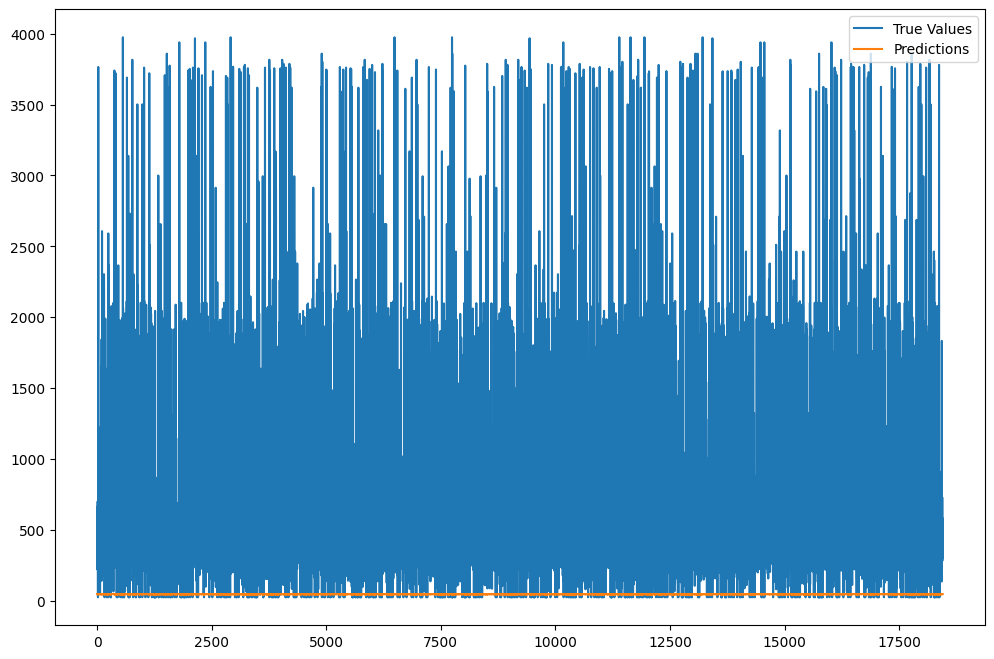

In [62]:
#predict the model
test_predictions = model.predict(x_test_shaped_scaled)
#inverse transform the predicted values
test_predictions = scaler.inverse_transform(test_predictions)
#inverse transform the actual values
y_test_scaled = scaler.inverse_transform(y_test_scaled)

#plot the predicted values against the actual values
plt.figure(figsize=(12,8))
plt.plot(y_test_scaled[:,1], label='True Values')
plt.plot(test_predictions[:,1], label='Predictions')
plt.legend()
plt.show()






In [ ]:
#save the model
nn_model.save('model.h5')

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default = "browser"

#load the model
from keras.models import load_model

model = load_model('model.h5')

#predict the next value on the test data with less rows
#reshape the data to get the expected input shape
X_test_scaled = scaler.fit_transform(X_test)
X_test_3d = X_test_scaled.reshape( -1, X_test_scaled.shape[0], X_test_scaled.shape[1])

#predict the next value
y_pred = model.predict(X_test_3d)



ValueError: in user code:

    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1805, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1794, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1787, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\training.py", line 1755, in predict_step
        return self(x, training=False)
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\joelw\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_33" is incompatible with the layer: expected shape=(None, 73795, 106), found shape=(None, 18449, 106)
